<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Classification with KNN


### LEARNING OBJECTIVES
*After this lesson, you will be able to explain:*
- Intuition behind the KNN algorithm
- Implementing KNN with sklearn
- Using classification metrics on multiclass classification

---



# K Nearest Neighbors classification walkthrough

From here on out we are going to look at how the kNN algorithm classifies an unknown point using the Iris dataset.

---

<a id='nonparametric'></a>

### Note on parametric vs. nonparametric methods

Thus far, all of our tests and methods have been **parametric**. That is, we have assumed a certain distribution for our data. In linear regression our parameters are the coefficients in our model, and our estimate of the target is calculated from these parameters.

There are alternatives in the case where we cannot assume a particular distribution for our data or choose not to. These methods are **nonparametric** When we make no assumptions about the distribution for our data, we call our data nonparametric. For nearly every parametric test, there is a nonparametric analog available. The KNN model is an example of a nonparametric model. You can see that there are no coefficients for the different predictors and our estimate is not represented by a formula of our predictor variables.

---

## kNN

![](https://snag.gy/hatSE6.jpg)

The pseudocode algorithm for kNN is as follows:



```
for unclassified_point in sample:
    for known_point in known_class_points:
        calculate distances (euclidean or other) between known_point and unclassified_point
    for k in range of specified_neighbors_number:
        find k_nearest_points in known_class_points to unclassified_point
    assign class to unclassified_point using "votes" from k_nearest_points
```
> ### Common KNN Distance Functions
> These distance functions can be used with KNN.  Euclidean is the most common choice.
>
> ### Euclidean  
> $\sqrt{\sum\limits_{i=1}^k(x_i - y_i)^2}$
>
> ### Manhattan 
> $\sum\limits_{i=1}^k \left| x_i - y_i \right|$
>
> ### Minkowski
> $\left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p}$

---

[NOTE: in the case of ties, `sklearn`'s `KNeighborsClassifier()` will just choose the first class using uniform weights! If this is unappealing to you you can change the weights keyword argument to 'distance'.]



## Importing libraries
---

We'll need the following libraries for this notebook:
1. `pandas`
2. `numpy`
3. `matplotlib` and `seaborn`
4. `KNeighborsClassifier` from `sklearn`'s `neighbors` module
5. The `load_iris` function from `sklearn`'s `datasets` module
6. `train_test_split` and `cross_val_score` from `sklearn`'s `model_selection` module
7. `StandardScaler` from `sklearn`'s `preprocessing` module

In [ ]:
# import the required libraries

%matplotlib inline

## The Iris Dataset
---

> The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other. - [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)

Most `sklearn` datasets can be ran as follows:
```python
data = load_iris()
```

In [ ]:
flowers = load_iris()

## `load_iris()` properties
---

The `data` variable has several important properties you'll need to be familiar with:
1. `data.data`: This is your `X`. In our case, it's a 150x4 matrix of features.
2. `data.target`: This is your `y`. It's an array of 150 values (0, 1, 2). Each index corresponds do a different species of Iris flower.
3. `data.feature_names`: These are the names of each of your 4 features (corresponding to the 4 columns in `data.data`
4. `data.target_names`: These are the names of your 3 Iris species: Setosa, Versicolor and Virginica. **The order in `data.target_names` corresponds to the index in `data.target`.**

##  Let's create a pandas DataFrame from load_iris()`


In [ ]:
df = pd.DataFrame(flowers.data, columns=flowers.feature_names)
df['species'] = flowers.target
df.head()

In [ ]:
# how many observations of each species are there?


## Data Exploration
---

Let's see if our `DataFrame` requires any cleaning. In the cells below:
1. Check the `dtypes` to make sure every column is numerical
2. Check for null values

Use `describe()` to check the mean, standard deviation, min and max values

Visualizing KNN
---

Let's create a scatter plot using two features from the `DataFrame`: `'petal length (cm)'` and `'petal width (cm)'`. Each dot should be colored according to its species.

In [ ]:
colors = ['red', 'green', 'blue']
color_series = df['species'].map(lambda s: colors[s])
plt.scatter(df['petal length (cm)'], df['petal width (cm)'], color=color_series)

## EDA: Pairplot
---

Let's expand on the scatter plot created in the previous step. We can use `seaborn`'s `.pairplot()` method to create scatter plots using all of our features.

In [ ]:
sns.pairplot(df, hue='species')

## Train/Test split
---

Use the `train_test_split` function to split your data into a training set and a holdout set.

Set `stratify=y` to ensure the proportions of each class are similar in the training and test sets.

In [ ]:
X = df[flowers.feature_names]
y = df['species']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

## `StandardScaler`
---

Because KNN is calculating the distance between neighbors, it's highly sensitive to the magnitude of your features. For example, if we were using KNN on a housing dataset, a feature like square footage (measured in **thousands** of feet^2) can really affect the distance. 

Thus, in order for KNN to work properly, it's important to scale our data. In the cells below, we will create an instance of `StandardScaler` and use it to transform `X_train` and `X_test`.

This will:
- calculate the mean and sd of the training data so that it can be transformed to the standard normal scale (mean = 0, sd = 1)
- Transform the test data using the same mean and sd from the training data 

In [ ]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Instantiate KNN
---

For the `KNeighborsClassifier`, there a few important parameters to keep in mind:

1. `n_neighbors`: this is the "K" in KNN. The best K will change from problem to problem, but the default is 5.
2. `weights`: The neighbors can all have an equal vote (`uniform`), or the closer points can have a higher weighted vote (`distance`).
3. `p`: The distance metric. The default is Euclidean distance (2). Changing it to 1 is setting the distance to Manhattan.

In the cell below, instantiate a `knn` model using the default parameters.

In [ ]:
# To compare results later, can try n_neighbors = 10 or another number
knn = KNeighborsClassifier()

## Cross validation
---

In the cell below, use `cross_val_score` to see what accuracy we can expect from our KNN model. The score will be an average from applying the model to each of the k-folds of the training set. 

Image from 
[Cross Validation Documentation](https://scikit-learn.org/stable/modules/cross_validation.html)


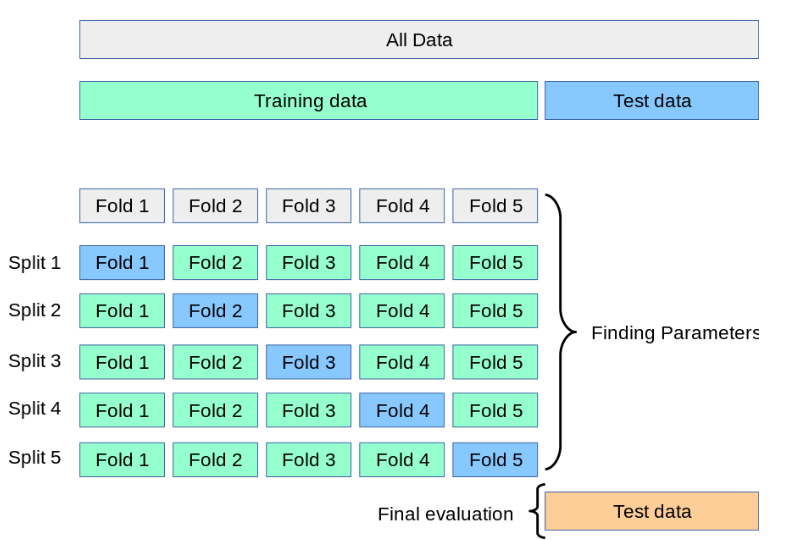

In [ ]:
cross_val_score(knn, X_train_sc, y_train, cv=10).mean()

## Model fitting and evaluation
---

Now that we know what we can expect from our KNN model, let's 
1. fit the model to `X_train_sc`, `y_train`
2. score it on `X_test_sc`, `y_test`

## Evaluation

Since we are trying to predict one of three species, this is a multi-class classification. Let's check the classification metrics for these.

First import the required metrics functions:

In [ ]:
# Import metrics.
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


Check the predictions by calling `predict()` and `predict_proba()` on X_test_sc

In [ ]:
y_hat = knn.predict(X_test_sc)
y_hat

In [ ]:
knn.predict_proba(X_test_sc)

## Confusion Matrix

Generate the confusion matrix. What will it look like now that we have three classes?

In [ ]:
cm = confusion_matrix(y_test, y_hat)

In [ ]:
cm

## Confusion DataFrame
---

Again we will create the pandas `DataFrame`.

In [ ]:
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

In [ ]:
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, y_hat), annot = True, xticklabels = flowers.target_names, yticklabels = flowers.target_names, cmap = 'summer_r')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# The accuracy score evaluates the percentage of correct classificatons
accuracy_score(y_test, y_hat)

In [ ]:
# Recall = sensitivity : TP/ (TP + FN)
# For multi class classification, to view the recall score for each label set average=None
recall_score(y_test, y_hat, average=None)

In [ ]:
# Similarly we can calculate precision
precision_score(y_test, y_hat, average=None)

## Conclusion

K-Nearest Neighbors estimates the class by calculating the distance to known observations and then classifying according to the majority of k-neighbors. 

We can also generate the classification metrics for multiclass classification but considering each class or by averaging the scores.